In [1]:
!conda list

# packages in environment at C:\ProgramData\Anaconda3\envs\stockPredict:
#
# Name                    Version                   Build  Channel
_tflow_select             2.3.0                     eigen  
absl-py                   0.15.0             pyhd3eb1b0_0  
aiohttp                   3.7.4                    pypi_0    pypi
aiosignal                 1.2.0              pyhd3eb1b0_0  
argcomplete               1.12.3             pyhd3eb1b0_0  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0           py37h2bbff1b_0  
astor                     0.8.1            py37haa95532_0  
astunparse                1.6.3                      py_0  
async-timeout             3.0.1                    pypi_0    pypi
asynctest                 0.13.0                     py_0  
attrs                     21.4.0             pyhd3eb1b0_0  
backcall                  0.2.0              pyhd3eb1b0_0  
blas                      1.0                         mkl  
bleach

In [15]:
# Package imports
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import csv
import yfinance
import pandas as pd
from datetime import timedelta
from scipy.signal import argrelextrema
from collections import defaultdict
import warnings
import time
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm
matplotlib.rcParams['figure.figsize'] = (8, 5)
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\envs\stockPredict\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['average', 'dot', 'concatenate', 'minimum', 'maximum', 'multiply', 'subtract', 'add']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
def get_data(symbol, lookback):
    all_data = pd.DataFrame()
    if lookback > 7:
        max_requests = lookback // 7
        date_left_to_request = lookback % 7
        endDate = pd.to_datetime('today')
        startDate = endDate - datetime.timedelta(days = 7)
        preStartDate = startDate
        cur_data = yfinance.download(symbol , startDate , endDate , interval= '1m')
        all_data = pd.concat([cur_data, all_data], axis = 0)
        for i in range(1, max_requests):
            cur_data = pd.DataFrame()
            endDate = preStartDate
            startDate = endDate - datetime.timedelta(days = 7)
            preStartDate = startDate
            cur_data = yfinance.download(symbol , startDate , endDate , interval= '1m')
            all_data = pd.concat([cur_data, all_data], axis = 0)
        endDate = preStartDate
        startDate = endDate - datetime.timedelta(days = date_left_to_request)
        cur_data = yfinance.download(symbol , startDate , endDate , interval= '1m')
        all_data = pd.concat([cur_data, all_data], axis = 0)
    else:      
        endDate = pd.to_datetime('today')
        startDate = endDate - datetime.timedelta(days = lookback)
        all_data = yfinance.download(symbol , startDate , endDate , interval= '1m')
    all_data.drop(columns=['Volume', 'Adj Close'], inplace=True)
    all_data.index.name = 'timestamp'
    all_data.replace(0, method='bfill', inplace=True)
    return all_data
        
def get_stock_data(stocklist, lookback):
    stock_data = {}
    for stock in tqdm(stocklist, desc='Getting stock data'):
        try:
            stock_data[stock] = get_data(stock, lookback)
        except Exception as e:
            print('Exception {} {}'.format(stock, e))
    return stock_data
def resample(stock_data, rate):
    for stock in stock_data:
        stock_data[stock] = stock_data[stock].resample(rate, closed='right', label='right').agg({'Open': 'first',
                                                                                                 'High': 'max',
                                                                                                 'Low': 'min',
                                                                                                 'Close': 'last'}).dropna()
    return stock_data

In [4]:
stocklist = ['AAPL']
stock_data = get_stock_data(stocklist, 29)

Getting stock data:   0%|                                                                        | 0/1 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Getting stock data: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.78s/it]

In [5]:
ema_list = [7]
window_list = [7]
resampled_stock_data = stock_data.copy()
resampled_stock_data = resample(resampled_stock_data, '5T')
resampled_stock_data

{'AAPL':                                  Open        High         Low       Close
 timestamp                                                                
 2022-02-22 09:30:00-05:00  164.979996  165.250000  164.330002  165.131393
 2022-02-22 09:35:00-05:00  165.420502  165.466202  163.850006  164.350006
 2022-02-22 09:40:00-05:00  164.339996  164.759995  164.255005  164.492203
 2022-02-22 09:45:00-05:00  164.500000  165.110001  164.370605  165.100006
 2022-02-22 09:50:00-05:00  165.250000  165.890503  165.160004  165.710007
 ...                               ...         ...         ...         ...
 2022-03-22 15:40:00-04:00  168.919998  169.005005  168.860001  168.889999
 2022-03-22 15:45:00-04:00  168.895004  169.179993  168.865005  168.975006
 2022-03-22 15:50:00-04:00  168.975006  169.250000  168.919998  169.029999
 2022-03-22 15:55:00-04:00  169.029999  169.044998  168.490005  168.610001
 2022-03-22 16:00:00-04:00  168.600006  169.029999  168.535004  168.820007
 
 [1659 rows x 4

In [6]:
def get_max_min(data,smoothing,window_range):
    smooth_prices = data['Close'].rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []
    for i in local_max:
        if (i>window_range) and (i<len(data)-window_range):
            price_local_max_dt.append(data.iloc[i-window_range:i+window_range]['Close'].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(data)-window_range):
            price_local_min_dt.append(data.iloc[i-window_range:i+window_range]['Close'].idxmin())
    maxima = pd.DataFrame(data.loc[price_local_max_dt])
    minima = pd.DataFrame(data.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    p = data.reset_index()   
    max_min['day_num'] = p[p['timestamp'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num')['Close']
    return max_min

In [7]:
def find_patterns(max_min):
    patterns = defaultdict(list)
    # Window range is 5 units
    for i in range(5, len(max_min)):  
        window = max_min.iloc[i-5:i]
        
        # Pattern must play out in less than n units
        if window.index[-1] - window.index[0] > 100:      
            continue   
            
        a, b, c, d, e = window.iloc[0:5]
        
        #Head & Shoulder
        #if a>b and c>a and c>e and c>d and abs(b-d)<=np.mean([b,d])*0.02:
            #patterns['HS'].append((window.index[0], window.index[-1]))
            
                
        # Inverted Head & Shoulder
        if a<b and c<a and c<e and c<d and e<d and abs(b-d)<=np.mean([b,d])*0.02:
            patterns['IHS'].append((window.index[0], window.index[-1]))
        
    return patterns

In [8]:
def screener(stock_data, ema_list, window_list):
    
    all_results = pd.DataFrame()
    
    for stock in stock_data:
        prices = stock_data[stock]
        
        for ema_ in ema_list:
            for window_ in window_list: 
                max_min = get_max_min(prices, smoothing=ema_, window_range=window_)
                pat = find_patterns(max_min)
    return pat

In [9]:
temp = screener(resampled_stock_data, ema_list, window_list)
#temp2 = resampled_stock_data['Close'].iloc[temp['HS'][0][0]:temp['HS'][0][1]]
train_X = []
train_Y = []
for pattern in temp['IHS']:
    delta = pattern[1] - pattern[0]
    if delta < 35:
        look_back = 35 - delta
        train_X.append(resampled_stock_data['AAPL']['Close'].iloc[pattern[0]-look_back:pattern[1]])
        train_Y.append(resampled_stock_data['AAPL']['Close'].iloc[pattern[1]+1])
train_X

[timestamp
 2022-03-10 14:45:00-05:00    158.311401
 2022-03-10 14:50:00-05:00    158.899994
 2022-03-10 14:55:00-05:00    158.924393
 2022-03-10 15:00:00-05:00    158.820007
 2022-03-10 15:05:00-05:00    158.559998
 2022-03-10 15:10:00-05:00    158.258606
 2022-03-10 15:15:00-05:00    158.419998
 2022-03-10 15:20:00-05:00    158.229996
 2022-03-10 15:25:00-05:00    157.896194
 2022-03-10 15:30:00-05:00    157.989899
 2022-03-10 15:35:00-05:00    157.869995
 2022-03-10 15:40:00-05:00    157.729904
 2022-03-10 15:45:00-05:00    157.845001
 2022-03-10 15:50:00-05:00    158.139999
 2022-03-10 15:55:00-05:00    158.570007
 2022-03-10 16:00:00-05:00    158.520004
 2022-03-11 09:30:00-05:00    158.960007
 2022-03-11 09:35:00-05:00    158.994995
 2022-03-11 09:40:00-05:00    157.949997
 2022-03-11 09:45:00-05:00    158.320007
 2022-03-11 09:50:00-05:00    158.225998
 2022-03-11 09:55:00-05:00    157.270004
 2022-03-11 10:00:00-05:00    156.979904
 2022-03-11 10:05:00-05:00    157.449997
 2022

In [10]:
train_X[0].index

DatetimeIndex(['2022-03-10 14:45:00-05:00', '2022-03-10 14:50:00-05:00',
               '2022-03-10 14:55:00-05:00', '2022-03-10 15:00:00-05:00',
               '2022-03-10 15:05:00-05:00', '2022-03-10 15:10:00-05:00',
               '2022-03-10 15:15:00-05:00', '2022-03-10 15:20:00-05:00',
               '2022-03-10 15:25:00-05:00', '2022-03-10 15:30:00-05:00',
               '2022-03-10 15:35:00-05:00', '2022-03-10 15:40:00-05:00',
               '2022-03-10 15:45:00-05:00', '2022-03-10 15:50:00-05:00',
               '2022-03-10 15:55:00-05:00', '2022-03-10 16:00:00-05:00',
               '2022-03-11 09:30:00-05:00', '2022-03-11 09:35:00-05:00',
               '2022-03-11 09:40:00-05:00', '2022-03-11 09:45:00-05:00',
               '2022-03-11 09:50:00-05:00', '2022-03-11 09:55:00-05:00',
               '2022-03-11 10:00:00-05:00', '2022-03-11 10:05:00-05:00',
               '2022-03-11 10:10:00-05:00', '2022-03-11 10:15:00-05:00',
               '2022-03-11 10:20:00-05:00', '2022-0

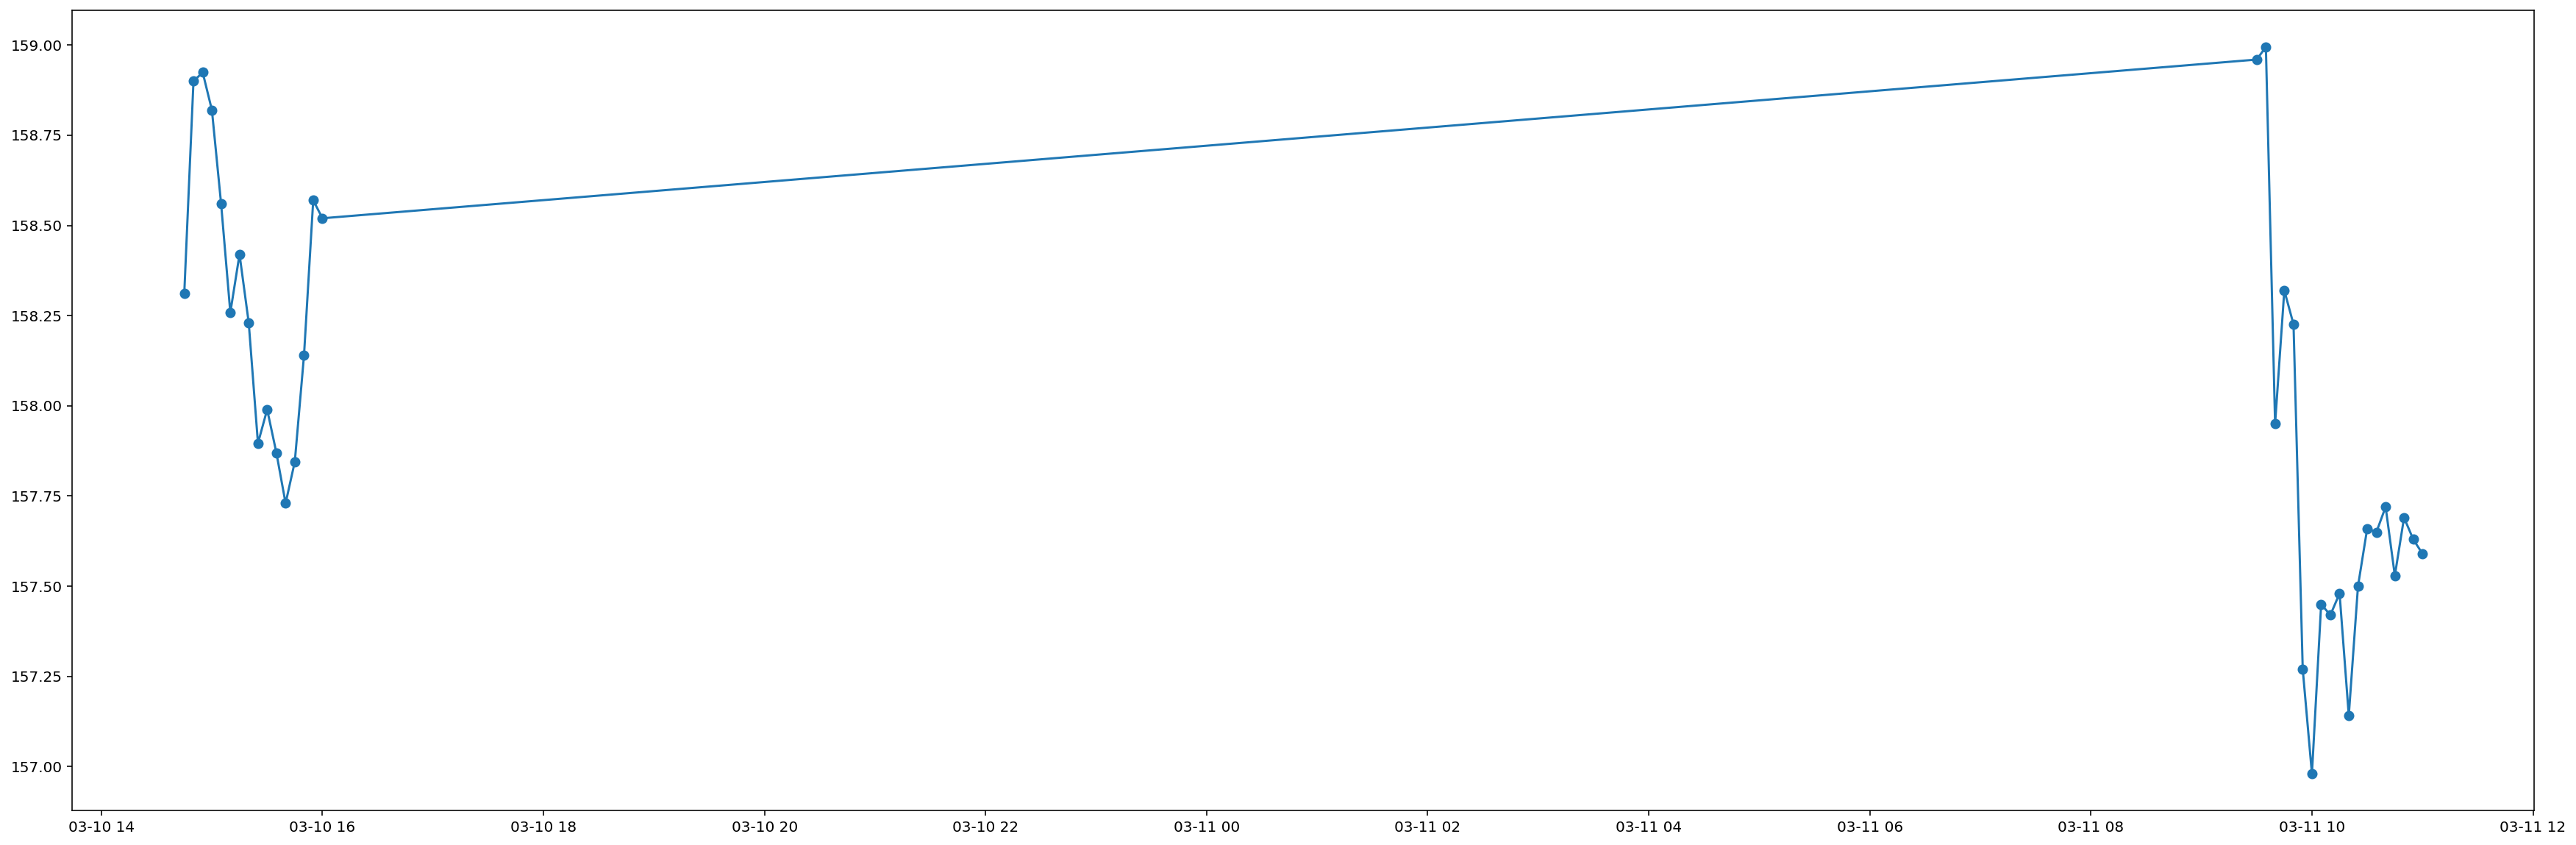

In [11]:
plt.rcParams["figure.figsize"] = (30,10)
plt.plot(train_X[0].index, train_X[0].values, '-o')
plt.savefig('IHS_detect_example.png')
plt.show()

In [27]:
def get_train_data_from_pattern_detect(stocks_data, ema_list, window_list, pattern_name, ):
    X = []
    Y = []
    for stock_name in stocks_data:
        stock_prices = stocks_data[stock_name]
        for ema_ in ema_list:
            for window_ in window_list: 
                max_min = get_max_min(stock_prices, smoothing=ema_, window_range=window_)
                patterns = find_patterns(max_min)
                for pattern in patterns[pattern_name]:
                    delta = pattern[1] - pattern[0]
                    look_back = 100 - delta
                    print(pattern)
                    if delta < 100 and pattern[0] - look_back > 0:
                        X.append(stock_prices['Close'].iloc[pattern[0]-look_back:pattern[1]])
                        Y.append(stock_prices['Close'].iloc[pattern[1]+1])
    return X, Y



trainX, trainY = get_train_data_from_pattern_detect(resampled_stock_data, ema_list, window_list, 'IHS')
trainX

(23, 76)
(332, 369)
(552, 589)
(706, 742)
(847, 890)
(972, 1022)
(1022, 1046)
(1342, 1371)
(1375, 1399)
(1493, 1542)


[timestamp
 2022-02-25 12:10:00-05:00    164.550003
 2022-02-25 12:15:00-05:00    164.229996
 2022-02-25 12:20:00-05:00    164.091400
 2022-02-25 12:25:00-05:00    164.111404
 2022-02-25 12:30:00-05:00    164.460007
                                 ...    
 2022-02-28 13:30:00-05:00    163.880997
 2022-02-28 13:35:00-05:00    163.789993
 2022-02-28 13:40:00-05:00    164.089996
 2022-02-28 13:45:00-05:00    164.014404
 2022-02-28 13:50:00-05:00    164.221405
 Name: Close, Length: 100, dtype: float64,
 timestamp
 2022-03-02 10:45:00-05:00    164.744995
 2022-03-02 10:50:00-05:00    164.910004
 2022-03-02 10:55:00-05:00    164.375000
 2022-03-02 11:00:00-05:00    164.360001
 2022-03-02 11:05:00-05:00    165.329193
                                 ...    
 2022-03-03 12:05:00-05:00    166.740005
 2022-03-03 12:10:00-05:00    166.949997
 2022-03-03 12:15:00-05:00    166.919998
 2022-03-03 12:20:00-05:00    166.990005
 2022-03-03 12:25:00-05:00    166.705002
 Name: Close, Length: 100, dtype:

***Prepair train data***

In [51]:
X_train = []
for X in trainX:
    X_train.append(X.values)
    
X_train = np.array(X_train)
Y_train = np.array(trainY)
Y_train = Y_train.reshape(Y_train.shape[0], 1)
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
Y_train = sc.fit_transform(Y_train)

#Make a 3D array data for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
Y_train = Y_train.reshape(Y_train.shape[0], 1, 1)
print(X_train.shape)
print(Y_train.shape)

(9, 100, 1)
(9, 1, 1)


In [52]:
X_train

array([[[0.97472558],
        [0.91542199],
        [0.95699776],
        [0.96241935],
        [0.88739931],
        [0.87858109],
        [0.8365406 ],
        [0.85157443],
        [0.84846741],
        [0.78919794],
        [0.80008663],
        [0.78983847],
        [0.75927753],
        [0.80314091],
        [0.81382997],
        [0.85447439],
        [0.84690332],
        [0.82380338],
        [0.81330775],
        [0.82099508],
        [0.87871153],
        [0.81273395],
        [0.83391165],
        [0.84967303],
        [0.79492958],
        [0.8534307 ],
        [0.86608016],
        [0.86534903],
        [0.82924424],
        [0.80486596],
        [0.79637081],
        [0.77808594],
        [0.7562874 ],
        [0.74893964],
        [0.73811967],
        [0.71200436],
        [0.72351632],
        [0.81547236],
        [0.76476545],
        [0.81269027],
        [0.78421288],
        [0.76813118],
        [0.78128466],
        [0.80749623],
        [0.81000226],
        [0

In [53]:
model = Sequential()

#Adding a first LSTM layer
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, Y_train, epochs = 10, batch_size = 32)
model.summary()

Epoch 1/10
1/1 [==============================] - 0s 999us/step - loss: 0.2476
Epoch 2/10
1/1 [==============================] - 0s 0s/step - loss: 0.1755
Epoch 3/10
1/1 [==============================] - 0s 998us/step - loss: 0.1162
Epoch 4/10
1/1 [==============================] - 0s 998us/step - loss: 0.0392
Epoch 5/10
1/1 [==============================] - 0s 999us/step - loss: 0.0243
Epoch 6/10
1/1 [==============================] - 0s 0s/step - loss: 0.0906
Epoch 7/10
1/1 [==============================] - 0s 997us/step - loss: 0.0453
Epoch 8/10
1/1 [==============================] - 0s 998us/step - loss: 0.0123
Epoch 9/10
1/1 [==============================] - 0s 0s/step - loss: 0.0112
Epoch 10/10
1/1 [==============================] - 0s 997us/step - loss: 0.0167
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100, 50)           10400    

In [54]:
X_test = resampled_stock_data['AAPL']['Close'].values[0:500]
X_test = X_test.reshape(X_test.shape[0], 1, 1)
#print(X_test.shape)
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price

array([[157.0766 ],
       [157.07663],
       [157.07663],
       [157.0766 ],
       [157.07657],
       [157.07657],
       [157.07658],
       [157.0766 ],
       [157.07658],
       [157.07657],
       [157.07657],
       [157.07657],
       [157.07655],
       [157.07657],
       [157.07657],
       [157.0766 ],
       [157.0766 ],
       [157.0766 ],
       [157.07661],
       [157.07661],
       [157.07661],
       [157.07661],
       [157.07661],
       [157.07663],
       [157.07661],
       [157.07661],
       [157.0766 ],
       [157.0766 ],
       [157.0766 ],
       [157.07661],
       [157.07661],
       [157.0766 ],
       [157.07661],
       [157.07663],
       [157.07663],
       [157.07663],
       [157.07663],
       [157.07663],
       [157.07663],
       [157.07663],
       [157.07663],
       [157.07663],
       [157.07663],
       [157.07663],
       [157.07663],
       [157.07664],
       [157.07664],
       [157.07664],
       [157.07664],
       [157.07664],
